In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
# import numpy as np
# import pandas as pd
# import pyspark.pandas as ps

import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.enableHiveSupport().appName('AmazonReviewRcommender').getOrCreate()
sc = spark.sparkContext

# Data Loading

In [4]:
df1 = spark.read.json("/user/ruixuan/FinalData/core.json")

In [5]:
df1.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [6]:
df1.count()

41135700

In [7]:
df2 = spark.read.json("/user/ruixuan/FinalMetadata/metadata.json")

In [8]:
df2.show(2)

+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791| null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561| null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
+---------------+----------+-----+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------

In [9]:
df2.count()

9430088

# Select Columns

In [10]:
# Show more than one column
df2.select("categories", "brand").show(5)

+--------------------+----------+
|          categories|     brand|
+--------------------+----------+
|           [[Books]]|      null|
|[[Movies & TV, Mo...|      null|
|[[Clothing, Shoes...|Big Dreams|
|[[Sports & Outdoo...|  BubuBibi|
|[[Sports & Outdoo...|   Unknown|
+--------------------+----------+
only showing top 5 rows



In [11]:
# List of distinct Results
df2.select('categories').distinct().show()

+--------------------+
|          categories|
+--------------------+
|[[Clothing, Shoes...|
|[[Pet Supplies, B...|
|[[Books, Parentin...|
|[[Sports & Outdoo...|
|[[Health & Person...|
|[[Sports & Outdoo...|
|[[Clothing, Shoes...|
|[[Home & Kitchen,...|
|[[Clothing, Shoes...|
|[[Electronics, Co...|
|[[Books, Christia...|
|[[Toys & Games, H...|
|[[Books, Literatu...|
|[[Electronics, Ca...|
|[[Miscellaneous, ...|
|[[Home & Kitchen,...|
|[[Pet Supplies, R...|
|[[Sports & Outdoo...|
|[[Electronics, Ca...|
|[[Clothing, Shoes...|
+--------------------+
only showing top 20 rows



In [12]:
# count the number of distinct Results
df2.select('categories').distinct().count()

348871

In [13]:
# Approximate Count of distinct facilities
from pyspark.sql.functions import approxCountDistinct

df2.select(approxCountDistinct("categories", rsd = 0.01)).show()

+---------------------------------+
|approx_count_distinct(categories)|
+---------------------------------+
|                           352007|
+---------------------------------+



# Missing Values

In [14]:
# Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df2.select([count(when(df2[c].isNull(), c)).alias(c) for c in df2.columns]).show()

+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+
|_corrupt_record|   asin|  brand|categories|description|  imUrl|  price|related|salesRank|  title|
+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+
|        8403388|1026700|7851678|   1096116|    4755417|1193791|4164158|3528377|  3254867|2377099|
+---------------+-------+-------+----------+-----------+-------+-------+-------+---------+-------+



In [15]:
# Count inspections with no missing values in the row
df2.dropna().count()

0

In [16]:
# there are no duplicate rows
df2.dropDuplicates().count()

9430088

# Data Merging & Cleaning

In [17]:
df = df1.join(df2, df1.asin == df2.asin, "inner").select(
    df1.asin, 
    df1.helpful,
    df1.overall, 
    df1.reviewText, 
    df1.reviewerID,
    df2.categories,
    df2.price,
    df2.related,
    df2.title
)

In [18]:
df.show(5)

+----------+-------+-------+--------------------+--------------+----------+-----+--------------------+---------------+
|      asin|helpful|overall|          reviewText|    reviewerID|categories|price|             related|          title|
+----------+-------+-------+--------------------+--------------+----------+-----+--------------------+---------------+
|0002216973| [1, 1]|    5.0|And to me, there'...| AESMLAZX4PI6L| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|From the dust jac...| AMVV8VYDTLA78| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [1, 1]|    5.0|There are only a ...| AHCOCJHM388I7| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [0, 0]|    5.0|I bought this boo...| ACUJMLOJEVYTB| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
|0002216973| [0, 0]|    5.0|I was looking out...|A39CS2IZHTQVJH| [[Books]]| null|[, [0812823354, 0...|Red Adam's Lady|
+----------+-------+-------+--------------------

# Visualization

## Top Reviews Per Item

In [19]:
df_top = df.groupby("asin").count().orderBy("count", ascending=False)

In [20]:
df_top.show()

+----------+-----+
|      asin|count|
+----------+-----+
|B00FAPF5U0|13550|
|B0051VVOB2|11981|
|030758836X|10552|
|0439023483|10404|
|B00DR0PDNE|10139|
|B007WTAJTO| 9771|
|B005SUHPO6| 8963|
|B0064X7B4A| 8808|
|B003ES5ZUU| 8137|
|B0063IH60K| 8113|
|B003ELYQGG| 7792|
|B005ZXWMUS| 7738|
|B00AWH595M| 7738|
|B007Q1W586| 7688|
|B000GF7ZRA| 7630|
|B0019EHU8G| 7591|
|B00DAHSVYC| 7186|
|0439023513| 7115|
|B00DJFIMW6| 6929|
|B00992CF6W| 6645|
+----------+-----+
only showing top 20 rows



In [21]:
df_top.summary().show()

+-------+--------------------+-----------------+
|summary|                asin|            count|
+-------+--------------------+-----------------+
|  count|             1280986|          1280986|
|   mean| 1.169338770485495E9|25.98162431127272|
| stddev|1.1683513903994262E9|86.87002726254771|
|    min|          0000013714|                5|
|    25%|        5.20252667E8|                6|
|    50%|        8.96894762E8|               10|
|    75%|       1.561011789E9|               21|
|    max|          BT008UKTMW|            13550|
+-------+--------------------+-----------------+



In [22]:
top_item = df.groupby("asin").count().orderBy("count", ascending=False).collect()

In [23]:
top_item

[Row(asin='B00FAPF5U0', count=13550),
 Row(asin='B0051VVOB2', count=11981),
 Row(asin='030758836X', count=10552),
 Row(asin='0439023483', count=10404),
 Row(asin='B00DR0PDNE', count=10139),
 Row(asin='B007WTAJTO', count=9771),
 Row(asin='B005SUHPO6', count=8963),
 Row(asin='B0064X7B4A', count=8808),
 Row(asin='B003ES5ZUU', count=8137),
 Row(asin='B0063IH60K', count=8113),
 Row(asin='B003ELYQGG', count=7792),
 Row(asin='B00AWH595M', count=7738),
 Row(asin='B005ZXWMUS', count=7738),
 Row(asin='B007Q1W586', count=7688),
 Row(asin='B000GF7ZRA', count=7630),
 Row(asin='B0019EHU8G', count=7591),
 Row(asin='B00DAHSVYC', count=7186),
 Row(asin='0439023513', count=7115),
 Row(asin='B00DJFIMW6', count=6929),
 Row(asin='B00992CF6W', count=6645),
 Row(asin='0375831002', count=6610),
 Row(asin='0385537859', count=6513),
 Row(asin='B009UX2YAC', count=6452),
 Row(asin='B0086700CM', count=6348),
 Row(asin='B00BWYQ9YE', count=6093),
 Row(asin='B009SYZ8OC', count=6000),
 Row(asin='B00FZM8Z7I', count=588

In [24]:
top_item[0][1]

13550

In [25]:
a = 0
b = 0
c = 0
d = 0
e = 0
for i in range(len(top_item)):
    if top_item[i][1] <= 5:
        a = a + 1
    elif top_item[i][1] > 5 and top_item[i][1] <= 10:
        b = b + 1
    elif top_item[i][1] > 10 and top_item[i][1] <= 20:
        c = c + 1
    elif top_item[i][1] > 20 and top_item[i][1] <= 30:
        d = d + 1
    else:
        e = e + 1        

In [26]:
print(a, b, c, d, e)

194209 465318 292984 111804 216671


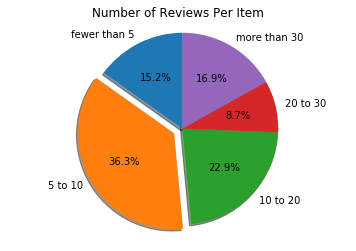

In [27]:
labels = 'fewer than 5', '5 to 10', '10 to 20', '20 to 30', 'more than 30'
sizes = [a, b, c, d, e]
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. '5 to 10')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Number of Reviews Per Item')

plt.show()

## Top Reviews Per Reviewer

In [28]:
top_reviewers = df.groupby("reviewerID").count().orderBy("count", ascending=False)

In [29]:
top_reviewers.summary().show()

+-------+--------------------+------------------+
|summary|          reviewerID|             count|
+-------+--------------------+------------------+
|  count|             3033430|           3033430|
|   mean|                null|10.971770240289045|
| stddev|                null|26.251632044030124|
|    min|A00005181SC9PSCD5...|                 1|
|    25%|                null|                 5|
|    50%|                null|                 7|
|    75%|                null|                11|
|    max|       AZZZYAYJQSDOJ|             17405|
+-------+--------------------+------------------+



In [30]:
top_reviewers = df.groupby("reviewerID").count().orderBy("count", ascending=False).collect()

In [31]:
a = 0
b = 0
c = 0
d = 0
e = 0
for i in range(len(top_reviewers)):
    if top_reviewers[i][1] <= 5:
        a = a + 1
    elif top_reviewers[i][1] > 5 and top_reviewers[i][1] <= 10:
        b = b + 1
    elif top_reviewers[i][1] > 10 and top_reviewers[i][1] <= 15:
        c = c + 1
    elif top_reviewers[i][1] > 15 and top_reviewers[i][1] <= 20:
        d = d + 1
    else:
        e = e + 1        

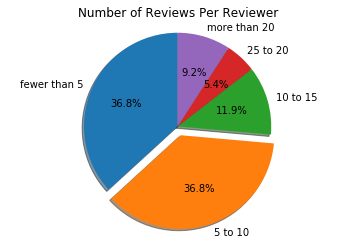

In [32]:
labels = 'fewer than 5', '5 to 10', '10 to 15', '25 to 20', 'more than 20'
sizes = [a, b, c, d, e]
explode = (0, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. '5 to 10')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Number of Reviews Per Reviewer')

plt.show()

## Top Reviews Per Category

In [33]:
df.groupby('categories').count().sort('count', ascending=False).show()

+--------------------+-------+
|          categories|  count|
+--------------------+-------+
|           [[Books]]|7421643|
|[[Movies & TV, Mo...|1524585|
|[[Apps for Androi...| 858058|
|[[Grocery & Gourm...| 624514|
|[[Cell Phones & A...| 512281|
| [[Movies & TV, TV]]| 438034|
|            [[Baby]]| 417403|
|[[Amazon Instant ...| 317234|
|[[Electronics, Co...| 214280|
|[[Electronics, Ac...| 167357|
|                null| 135394|
|                [[]]| 122966|
|   [[Digital Music]]| 118995|
|    [[Buy a Kindle]]| 101808|
|[[Cell Phones & A...|  86305|
|[[Office Products...|  79394|
|[[Electronics, Ac...|  77938|
|[[Apps for Androi...|  72966|
|[[Video Games, PC...|  65464|
|[[Electronics, Co...|  60034|
+--------------------+-------+
only showing top 20 rows



In [34]:
categories_num = df2.groupBy(df2.categories[0][0]).count().sort("count", ascending=False).collect()

In [35]:
categories_num

[Row(categories[0][0]='Books', count=2087876),
 Row(categories[0][0]='Clothing, Shoes & Jewelry', count=1421208),
 Row(categories[0][0]=None, count=1096116),
 Row(categories[0][0]='Sports & Outdoors', count=450035),
 Row(categories[0][0]='CDs & Vinyl', count=434778),
 Row(categories[0][0]='Electronics', count=424575),
 Row(categories[0][0]='Home & Kitchen', count=354541),
 Row(categories[0][0]='Cell Phones & Accessories', count=328932),
 Row(categories[0][0]='Automotive', count=295361),
 Row(categories[0][0]='Toys & Games', count=272358),
 Row(categories[0][0]='Digital Music', count=270371),
 Row(categories[0][0]='Beauty', count=243596),
 Row(categories[0][0]='Health & Personal Care', count=231223),
 Row(categories[0][0]='Tools & Home Improvement', count=219061),
 Row(categories[0][0]='Grocery & Gourmet Food', count=159628),
 Row(categories[0][0]='Movies & TV', count=159073),
 Row(categories[0][0]='', count=153816),
 Row(categories[0][0]='Office Products', count=111690),
 Row(categorie

In [36]:
primary_type = "Books"
df_book_review = df.select("reviewerID").where(df.categories[0][0] == primary_type)

In [37]:
book_review = df_book_review.groupby("reviewerID").count().sort('count', ascending=False)

In [38]:
book_review.collect()

[Row(reviewerID='AFVQZQ8PW0L', count=17387),
 Row(reviewerID='A14OJS0VWMOSWO', count=13439),
 Row(reviewerID='A2F6N60Z96CAJI', count=4109),
 Row(reviewerID='A320TMDV6KCFU', count=3634),
 Row(reviewerID='A13QTZ8CIMHHG4', count=2601),
 Row(reviewerID='AHUT55E980RDR', count=2417),
 Row(reviewerID='A328S9RN3U5M68', count=2377),
 Row(reviewerID='A2TX179XAT5GRP', count=1930),
 Row(reviewerID='A2VKWLCNZF4ZVB', count=1846),
 Row(reviewerID='A21NVBFIEQWDSG', count=1833),
 Row(reviewerID='A1S3C5OFU508P3', count=1824),
 Row(reviewerID='A1X8VZWTOG8IS6', count=1783),
 Row(reviewerID='A1K1JW1C5CUSUZ', count=1639),
 Row(reviewerID='A1I2O9Y3X3HXLS', count=1503),
 Row(reviewerID='A1JLU5H1CCENWX', count=1482),
 Row(reviewerID='A2EDZH51XHFA9B', count=1363),
 Row(reviewerID='A2OJW07GQRNJUT', count=1269),
 Row(reviewerID='A22RY8N8CNDF3A', count=1265),
 Row(reviewerID='A1CNQTCRQ35IMM', count=1263),
 Row(reviewerID='A2VXSQHJWZAQGY', count=1262),
 Row(reviewerID='A1JKGTL51HHTU1', count=1248),
 Row(reviewerID=

In [39]:
book_review.summary().show()

+-------+--------------------+------------------+
|summary|          reviewerID|             count|
+-------+--------------------+------------------+
|  count|             1645151|           1645151|
|   mean|                null| 5.540991677967554|
| stddev|                null|25.029564810312525|
|    min|A00005181SC9PSCD5...|                 1|
|    25%|                null|                 1|
|    50%|                null|                 3|
|    75%|                null|                 5|
|    max|       AZZZT14MS21I6|             17387|
+-------+--------------------+------------------+



In [40]:
book_collect = book_review.collect()

In [41]:
a = 0
b = 0
c = 0
d = 0
e = 0
for i in range(len(book_collect)):
    if book_collect[i][1] <= 1:
        a = a + 1
    elif book_collect[i][1] > 1 and book_collect[i][1] <= 3:
        b = b + 1
    elif book_collect[i][1] > 3 and book_collect[i][1] <= 5:
        c = c + 1
    elif book_collect[i][1] > 5 and book_collect[i][1] <= 10:
        d = d + 1
    else:
        e = e + 1        

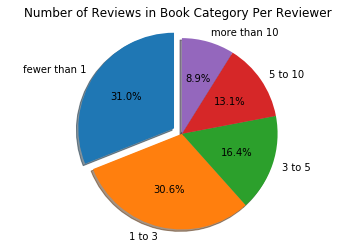

In [42]:
labels = 'fewer than 1', '1 to 3', '3 to 5', '5 to 10', 'more than 10'
sizes = [a, b, c, d, e]
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'fewer than 1')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Number of Reviews in Book Category Per Reviewer')

plt.show()

In [48]:
def plot_cate(primary_type):
    cate_review = df.select("reviewerID").where(df.categories[0][0] == primary_type)
    cate_review_collect = cate_review.groupby("reviewerID").count().sort('count', ascending=False).collect()
    a = 0
    b = 0
    c = 0
    d = 0
    e = 0
    for i in range(len(cate_review_collect)):
        if book_collect[i][1] <= 1:
            a = a + 1
        elif book_collect[i][1] > 1 and book_collect[i][1] <= 3:
            b = b + 1
        elif book_collect[i][1] > 3 and book_collect[i][1] <= 5:
            c = c + 1
        elif book_collect[i][1] > 5 and book_collect[i][1] <= 10:
            d = d + 1
        else:
            e = e + 1 
    labels = 'fewer than 1', '1 to 3', '3 to 5', '5 to 10', 'more than 10'
    sizes = [a, b, c, d, e]
    explode = (0.1, 0, 0, 0, 0) 

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title('Number of Reviews in {} Per Reviewer'.format(primary_type))

    plt.savefig(f"./{primary_type}.png")
    plt.show()

    

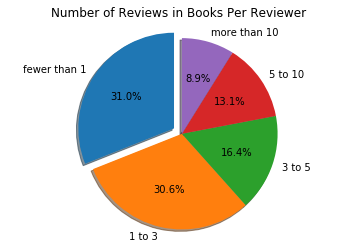

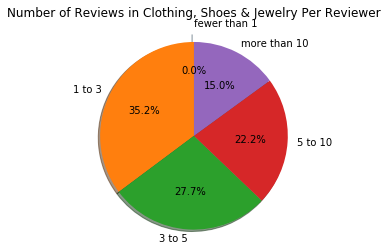

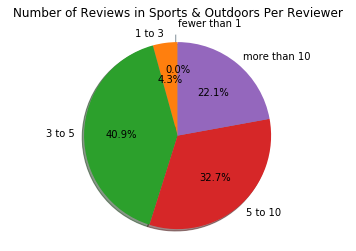

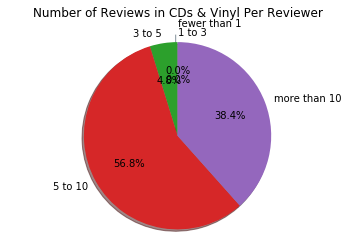

In [49]:
cate_list = ['Books', 'Clothing, Shoes & Jewelry', 'Sports & Outdoors', 'CDs & Vinyl']
for i in cate_list:
    plot_cate(i)